# 🐧 Penguin PCA Analysis

This notebook performs Principal Component Analysis (PCA) on the Palmer Penguins dataset to explore relationships between physical characteristics and species differentiation.

## 📦 Import Libraries

In [ ]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style='whitegrid')

## 📊 Data Loading and Preprocessing

In [6]:
# Load the dataset
df = pd.read_excel('../data/penguins.xlsx') 

In [7]:
# Separate numerical and categorical features
numerical_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
categorical_features = ['species', 'island', 'sex']

In [10]:
# Generate a list with the names of the numerical features
variables = list(df[numerical_features].columns)  
variables

['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

## 🔍 Exploratory Data Analysis

In [12]:
# Display basic statistics
df[numerical_features].describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057
std,5.468668,1.969235,14.015765,805.215802
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.600000,18.700000,213.000000,4775.000000
max,59.600000,21.500000,231.000000,6300.000000


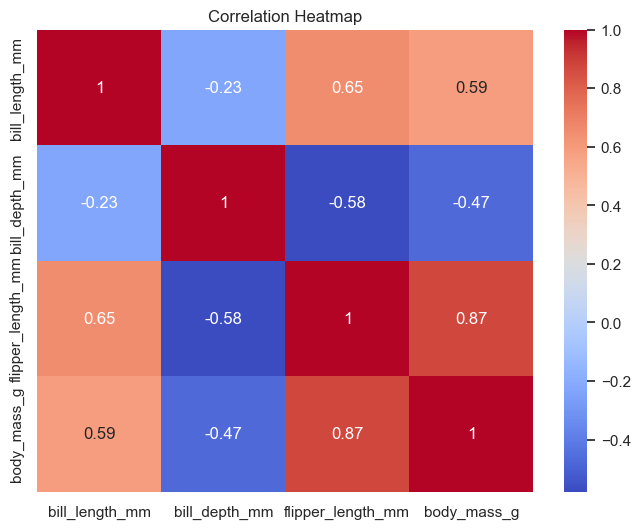

In [13]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## 📉 Principal Component Analysis

In [ ]:
# Standardize the numerical features
df_standardized = pd.DataFrame(
    StandardScaler().fit_transform(df[numerical_features]),  # Datos estandarizados
    columns=['{}_z'.format(variable) for variable in variables],  # Nombres de columnas estandarizadas
    index=df.index  
)

df_standardized.head(5)

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z
0,-0.896042,0.780732,-1.426752,-0.568475
1,-0.822788,0.119584,-1.069474,-0.506286
2,-0.676280,0.424729,-0.426373,-1.190361
3,-1.335566,1.085877,-0.569284,-0.941606
4,-0.859415,1.747026,-0.783651,-0.692852


In [21]:
# Perform PCA for the total number of variables
pca = PCA(n_components=len(variables))
fit = pca.fit(df_standardized)
eigenvalues = fit.explained_variance_

In [ ]:
# Create a DataFrame with eigenvalues and explained variance
explained_var = fit.explained_variance_ratio_ * 100
cumulative_var = np.cumsum(explained_var)
tabla = pd.DataFrame({
    'Eigenvalues': eigenvalues,
    'Explained Variance (%)': explained_var,
    'Cumulative Variance (%)': cumulative_var
}, index=['Component {}'.format(i) for i in range(1, 5)])
tabla

,Eigenvalues,Explained Variance (%),Cumulative Variance (%)
Component 1,2.753625,68.633893,68.633893
Component 2,0.780461,19.452929,88.086822
Component 3,0.369753,9.216063,97.302885
Component 4,0.108210,2.697115,100.000000


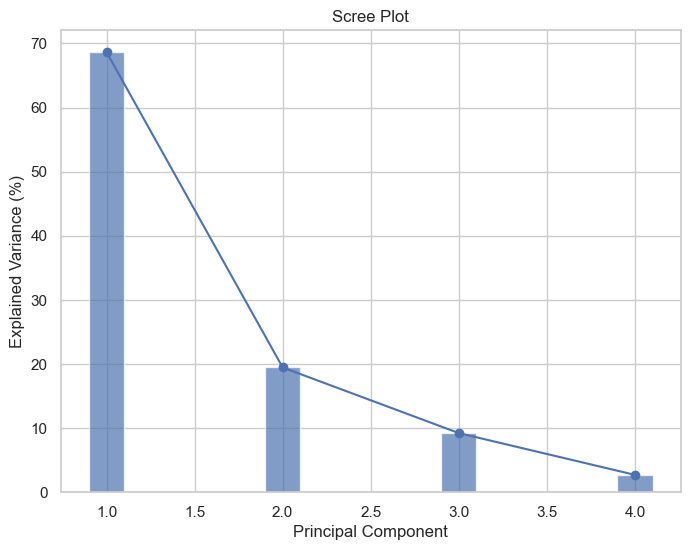

In [27]:
# Visualize the explained variance to determine the optimal number of components
plt.figure(figsize=(8, 6))
plt.plot(range(1, 5), explained_var, marker='o')
plt.bar(range(1, 5), explained_var, width=0.2, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

In [29]:
# Perform PCA with 2 components
pca = PCA(n_components=2)
fit = pca.fit(df_standardized)
results_pca = pd.DataFrame(fit.transform(df_standardized),
                              columns=['Component 1', 'Component 2'],
                              index=df_standardized.index)
df_standardized_cp = pd.concat([df_standardized, results_pca], axis=1)
df_standardized_cp.head()

,bill_length_mm_z,bill_depth_mm_z,flipper_length_mm_z,body_mass_g_z,Component 1,Component 2
0,-0.896042,0.780732,-1.426752,-0.568475,-1.853593,0.032069
1,-0.822788,0.119584,-1.069474,-0.506286,-1.316254,-0.443527
2,-0.676280,0.424729,-0.426373,-1.190361,-1.376605,-0.161230
3,-1.335566,1.085877,-0.569284,-0.941606,-1.885288,-0.012351
4,-0.859415,1.747026,-0.783651,-0.692852,-1.919981,0.817598


## 🧾Evaluate the results

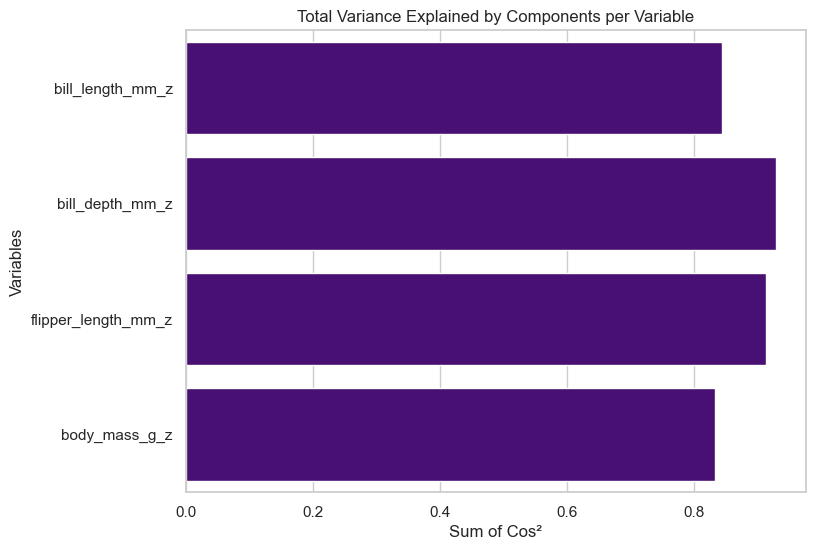

In [36]:
# Calculate the correlations between variables and components
correlations = df_standardized_cp.corr().iloc[:len(variables), len(variables):]

# Calculate the cos² values for the heatmap
cos2 = correlations**2

# Visualize the cos² values
plt.figure(figsize=(8, 6))
sns.barplot(x=cos2.sum(axis=1), y=cos2.index, color='indigo')
plt.xlabel('Sum of Cos²')
plt.ylabel('Variables')
plt.title('Total Variance Explained by Components per Variable')
plt.show()

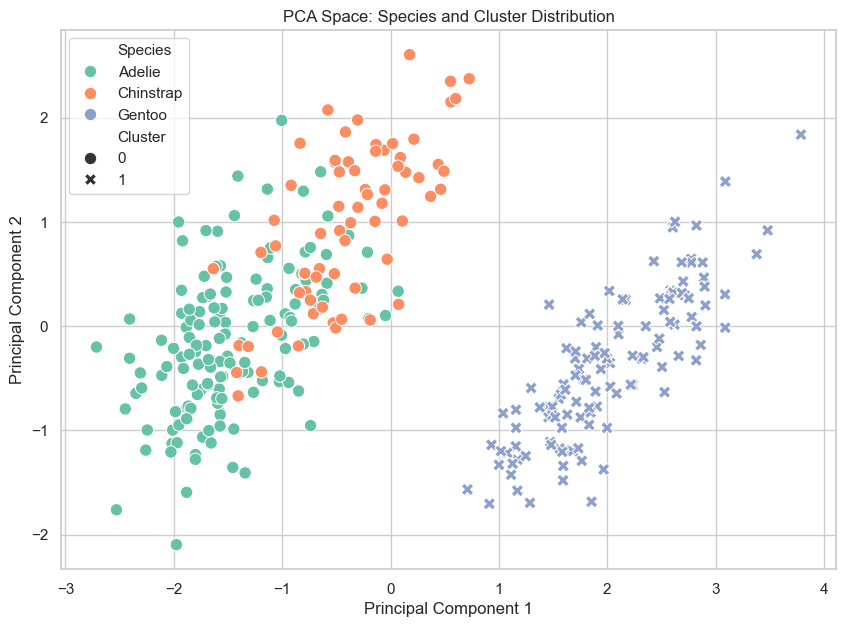

In [ ]:
# Fit KMeans clustering (k=2, as explained in the Clustering file)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(results_pca)
df_standardized_cp['Clusters'] = clusters
df_standardized_cp['Species'] = df['species']

# Scatter plot of PCA components colored by species and shaped by cluster
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='Component 1', y='Component 2',
    hue='Species', style='Cluster',
    data=df_standardized_cp, palette='Set2', s=80
) 
plt.title('PCA Space: Species and Cluster Distribution')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## ✅ Conclusions
- PCA effectively reduced the dimensionality of the penguin dataset, capturing most of the variance in the first two components.
- The scatter plot in PCA space shows clear separation between species, indicating that physical measurements are strong differentiators.
- KMeans clustering in PCA space aligns well with species labels, suggesting that unsupervised clustering can recover biological groupings.
- The cos² analysis confirms that most variables contribute significantly to the principal components, validating the use of PCA for this dataset.